<a href="https://colab.research.google.com/github/Minach2002/deep-learning-projects/blob/model-2/speech2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
dataset_path = "/content/drive/My Drive/RAVDESS"

In [3]:
emotion_labels = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

In [5]:
data = []

for actor in sorted(os.listdir(dataset_path)):
   actor_path = os.path.join(dataset_path,actor)        # load actor

   if os.path.isdir(actor_path):
     for file in sorted(os.listdir(actor_path)):
        if file.endswith(".wav"):

           parts = file.split("-")
           emotion_code = parts[2]
           emotion = emotion_labels.get(emotion_code,"unknown")

           file_path = os.path.join(actor_path,file)
           y, sr = librosa.load(file_path, sr=None)

           data.append( (file_path,emotion,sr,len(y)) )

In [11]:
df = pd.DataFrame(data, columns=["file_path","emotion","sample_rate","Audio Lenght"])
print(df.head())

                                           file_path  emotion  sample_rate  \
0  /content/drive/My Drive/RAVDESS/Actor_01/03-01...  neutral        48000   
1  /content/drive/My Drive/RAVDESS/Actor_01/03-01...  neutral        48000   
2  /content/drive/My Drive/RAVDESS/Actor_01/03-01...  neutral        48000   
3  /content/drive/My Drive/RAVDESS/Actor_01/03-01...  neutral        48000   
4  /content/drive/My Drive/RAVDESS/Actor_01/03-01...     calm        48000   

   Audio Lenght  
0        158558  
1        160160  
2        156956  
3        152152  
4        169769  


In [12]:
label_mapping = {v: int(k) for k,v in emotion_labels.items()}
df['encoded_label']= df['emotion'].map(label_mapping)

print(df[["emotion", "encoded_label"]].head(15))

    emotion  encoded_label
0   neutral              1
1   neutral              1
2   neutral              1
3   neutral              1
4      calm              2
5      calm              2
6      calm              2
7      calm              2
8      calm              2
9      calm              2
10     calm              2
11     calm              2
12    happy              3
13    happy              3
14    happy              3


In [13]:
print(df["sample_rate"].value_counts())

sample_rate
48000    1440
Name: count, dtype: int64


In [14]:
print('\nAudio Duration ')
print(df['Audio Lenght'].describe())


Audio Duration 
count      1440.000000
mean     177631.911111
std       16160.430333
min      140941.000000
25%      166567.000000
50%      176176.000000
75%      185786.000000
max      253053.000000
Name: Audio Lenght, dtype: float64


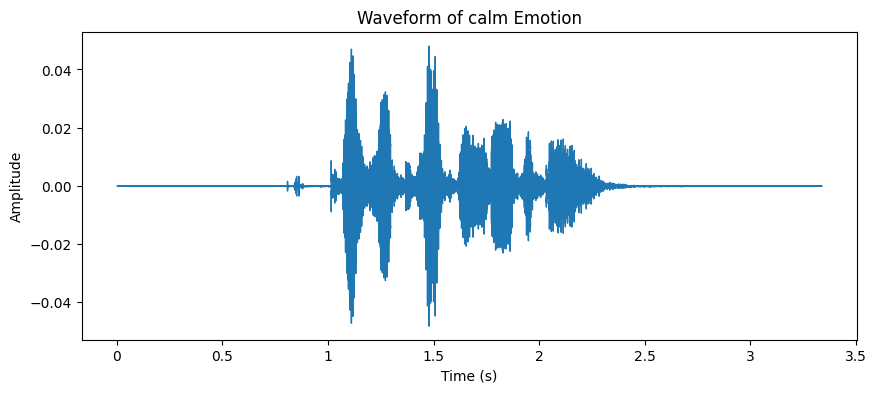

In [19]:
sample_audio = df.iloc[1]["file_path"]
y , sr = librosa.load(sample_audio, sr=None)

plt.figure(figsize=(10,4))
librosa.display.waveshow(y,sr=sr)
plt.title(f"Waveform of {df.iloc[9]['emotion']} Emotion")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

Lets preprocess

In [32]:
class SpeechEmotionDataset(Dataset):
    def __init__(self, df, processor, max_lenght=32000):
        self.df=df
        self.processor=processor
        self.max_lenght=max_lenght

    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        audio_path = self.df.iloc[idx]['file_path']
        label = self.df.iloc[idx]['encoded_label']

        speech, sr = librosa.load(audio_path, sr=None)

        if len(speech) > self.max_length:
            speech = speech[:self.max_length]
        else:
            speech = np.pad(speech, (0, self.max_length - len(speech)), 'constant')

        inputs = self.processor(
            speech,
            sampling_rate=16000,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=self.max_length
        )

        input_values =  inputs.input_values.squeeze(0)
        label = torch.tensor(label, dtype=torch.long)

        return {
            'input_values': inputs.input_values.squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

Train-test-splitting

In [25]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [28]:
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['encoded_label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=1/3, stratify=temp_df['encoded_label'], random_state=42)

Model building

In [31]:
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification
import torch

model_name = "ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
model = Wav2Vec2ForSequenceClassification.from_pretrained(model_name)



model.safetensors:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Some weights of the model checkpoint at ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition were not used when initializing Wav2Vec2ForSequenceClassification: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.output.bias', 'classifier.output.weight']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition and are newly initialized: ['classifier.bias', 'classifier.weight', '

In [29]:
train_dataset = SpeechEmotionDataset(train_df, processor)
val_dataset = SpeechEmotionDataset(val_df, processor)
test_dataset = SpeechEmotionDataset(test_df, processor)

NameError: name 'processor' is not defined